In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))


TensorFlow: 2.19.0
GPU available: False


In [3]:
ds = load_dataset(
    "koliskos/fake_news",
    data_files={"fake": "Fake.csv", "true": "True.csv"}
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Fake.csv:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

True.csv:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating fake split: 0 examples [00:00, ? examples/s]

Generating true split: 0 examples [00:00, ? examples/s]

In [4]:
print(ds)
print(ds.keys())

DatasetDict({
    fake: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 23481
    })
    true: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 21417
    })
})
dict_keys(['fake', 'true'])


In [5]:
df_fake = ds["fake"].to_pandas()
df_true = ds["true"].to_pandas()

df_fake["label"] = 0  # fake
df_true["label"] = 1  # true

df = pd.concat([df_fake, df_true], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [6]:
print("Final dataset shape:", df.shape)
print("Label distribution:\n", df["label"].value_counts())


Final dataset shape: (44898, 5)
Label distribution:
 label
0    23481
1    21417
Name: count, dtype: int64


In [7]:
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", " ", text)       # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)            # keep only letters + spaces
    text = re.sub(r"\s+", " ", text).strip()         # normalize whitespace
    return text


In [8]:
# Combine title + text (stronger than text alone)
df["content"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()
df["content_clean"] = df["content"].apply(clean_text)

# Basic sanity checks
print("Example cleaned text:\n", df["content_clean"].iloc[0][:300])
print("Missing cleaned:", df["content_clean"].isna().sum())



Example cleaned text:
 ben stein calls out th circuit court committed a coup d tat against the constitution st century wire says ben stein reputable professor from pepperdine university also of some hollywood fame appearing in tv shows and films such as ferris bueller s day off made some provocative statements on judge je
Missing cleaned: 0


In [9]:
X_text = df["content_clean"].astype(str).values
y = df["label"].astype(int).values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text, y_train, test_size=0.20, random_state=42, stratify=y_train
)

print("Train:", len(X_train_text), "Val:", len(X_val_text), "Test:", len(X_test_text))
print("Train label dist:", np.bincount(y_train))

Train: 28734 Val: 7184 Test: 8980
Train label dist: [15028 13706]


In [10]:
MAX_WORDS = 30000   # vocab size
MAX_LEN   = 300     # max tokens per article

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

print("Padded shapes:", X_train_pad.shape, X_val_pad.shape, X_test_pad.shape)



Padded shapes: (28734, 300) (7184, 300) (8980, 300)


In [15]:
def eval_and_plot(model, Xte, yte, title="Model"):
    # Predictions
    probs = model.predict(Xte, batch_size=512).ravel()
    preds = (probs >= 0.5).astype(int)

    # Metrics
    acc = accuracy_score(yte, preds)
    f1  = f1_score(yte, preds)
    roc = roc_auc_score(yte, probs)
    pr  = average_precision_score(yte, probs)

    # ---- Print metrics
    print("\n" + "="*70)
    print(title)
    print("Accuracy:", round(acc, 4))
    print("F1      :", round(f1, 4))
    print("ROC-AUC :", round(roc, 4))
    print("PR-AUC  :", round(pr, 4))
    print("\nClassification Report:\n",
          classification_report(yte, preds, digits=4))

    # ---- Confusion Matrix
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(
        yte, preds, ax=ax, values_format="d"
    )
    ax.set_title(f"Confusion Matrix — {title}")
    plt.tight_layout()
    plt.show()

    # ---- ROC Curve
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(yte, probs, ax=ax)
    ax.set_title(f"ROC Curve — {title}")
    plt.tight_layout()
    plt.show()

    # ---- Precision–Recall Curve
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(yte, probs, ax=ax)
    ax.set_title(f"Precision–Recall Curve — {title}")
    plt.tight_layout()
    plt.show()

    return {
        "model": title,
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr
    }


In [16]:
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")


In [17]:
# Fit tokenizer ONLY on training text (prevents data leakage)
tokenizer.fit_on_texts(X_train_text)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq   = tokenizer.texts_to_sequences(X_val_text)
X_test_seq  = tokenizer.texts_to_sequences(X_test_text)

print("Example sequence:", X_train_seq[0][:30])


Example sequence: [260, 25359, 4, 1794, 3261, 10, 3151, 855, 318, 648, 5398, 1306, 8036, 71, 68, 5, 2176, 450, 227, 318, 6, 855, 1209, 494, 3, 5398, 461, 212, 13225, 14864]


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

print("Padded shapes:", X_train_pad.shape, X_val_pad.shape, X_test_pad.shape)


Padded shapes: (28734, 300) (7184, 300) (8980, 300)


In [19]:
from tensorflow import keras
from tensorflow.keras import layers

cnn_model = keras.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),

    layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
    layers.GlobalMaxPooling1D(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])

cnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc")
    ]
)

cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 959ms/step

Keras CNN (Text-CNN)
Accuracy: 0.4756
F1      : 0.6255
ROC-AUC : 0.4974
PR-AUC  : 0.4736

Classification Report:
               precision    recall  f1-score   support

           0     0.4906    0.0720    0.1255      4696
           1     0.4744    0.9181    0.6255      4284

    accuracy                         0.4756      8980
   macro avg     0.4825    0.4950    0.3755      8980
weighted avg     0.4828    0.4756    0.3641      8980



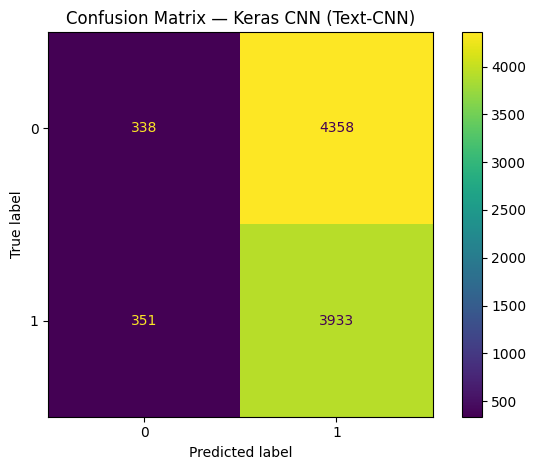

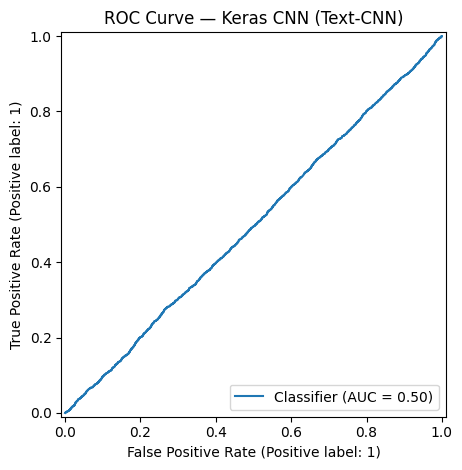

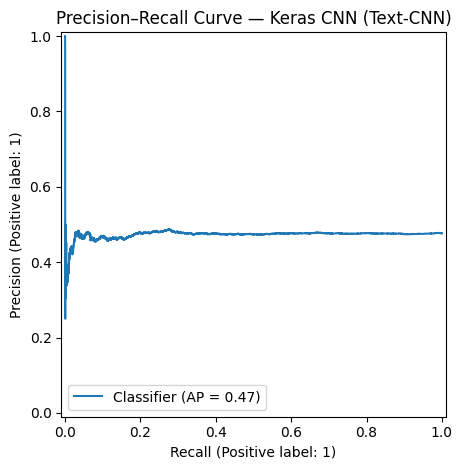

In [20]:
cnn_metrics = eval_and_plot(
    cnn_model,
    X_test_pad,
    y_test,
    title="Keras CNN (Text-CNN)"
)


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train
)

class_weight_dict = {0: float(class_weights[0]), 1: float(class_weights[1])}
print("class_weight:", class_weight_dict)


class_weight: {0: 0.9560154378493478, 1: 1.0482270538450313}


In [22]:
from tensorflow import keras
from tensorflow.keras import layers

cnn_model_v2 = keras.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=200, input_length=MAX_LEN),

    layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=5, activation="relu"),
    layers.GlobalMaxPooling1D(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])

cnn_model_v2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.AUC(name="auc")
    ]
)

cnn_model_v2.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=3,
        restore_best_weights=True
    )
]

cnn_history_v2 = cnn_model_v2.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=15,
    batch_size=256,
    class_weight=class_weight_dict,   # key fix
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.7707 - auc: 0.8450 - loss: 0.3998 - val_accuracy: 0.9975 - val_auc: 0.9997 - val_loss: 0.0100
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9982 - auc: 0.9996 - loss: 0.0094 - val_accuracy: 0.9979 - val_auc: 0.9994 - val_loss: 0.0092
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.9995 - auc: 0.9999 - loss: 0.0030 - val_accuracy: 0.9979 - val_auc: 0.9993 - val_loss: 0.0104
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.9996 - auc: 0.9999 - loss: 0.0024 - val_accuracy: 0.9979 - val_auc: 0.9994 - val_loss: 0.0113


18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step

Keras CNN v2 (class_weight + stronger embedding)
Accuracy: 0.9979
F1      : 0.9978
ROC-AUC : 0.9997
PR-AUC  : 0.9998

Classification Report:
               precision    recall  f1-score   support

           0     0.9983    0.9977    0.9980      4696
           1     0.9974    0.9981    0.9978      4284

    accuracy                         0.9979      8980
   macro avg     0.9979    0.9979    0.9979      8980
weighted avg     0.9979    0.9979    0.9979      8980



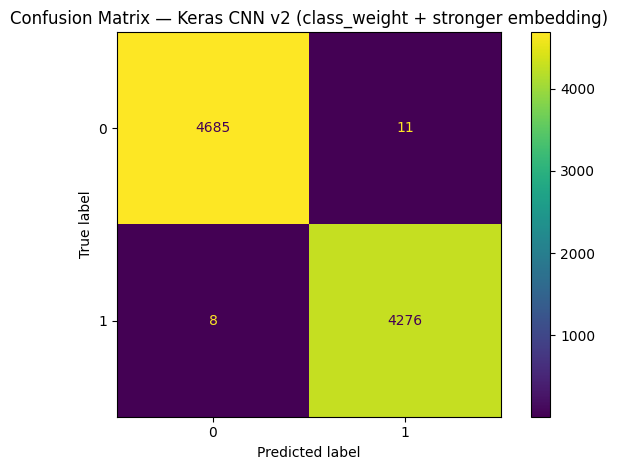

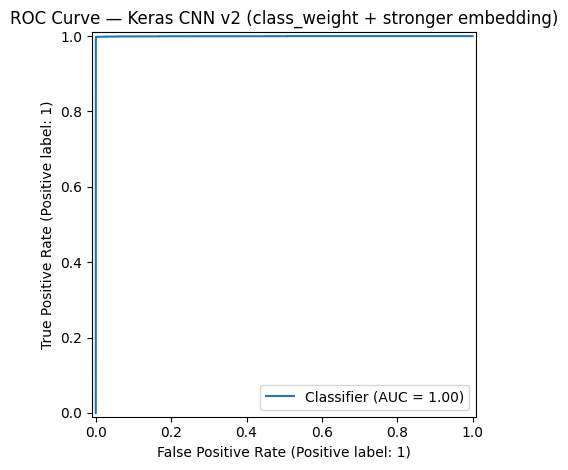

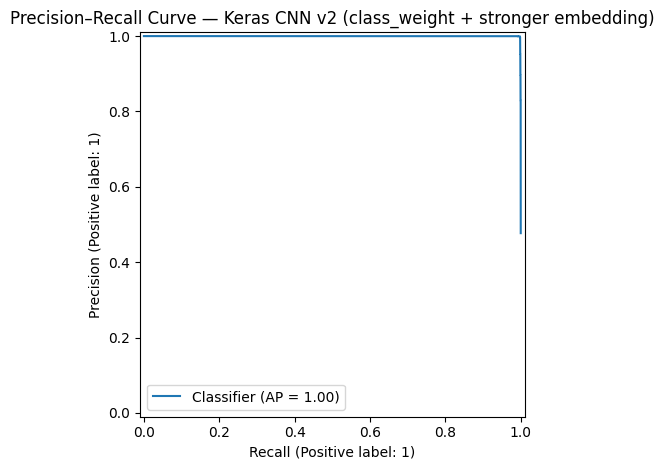

{'model': 'Keras CNN v2 (class_weight + stronger embedding)',
 'accuracy': 0.9978841870824053,
 'f1': 0.997783222494458,
 'roc_auc': np.float64(0.9997346610421568),
 'pr_auc': np.float64(0.9997748461977323)}

In [24]:
cnn_v2_metrics = eval_and_plot(
    cnn_model_v2,
    X_test_pad,
    y_test,
    title="Keras CNN v2 (class_weight + stronger embedding)"
)

cnn_v2_metrics


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
cnn_v1_metrics = {
    "model": "Keras CNN v1 (no class_weight)",
    "accuracy": 0.4756,
    "f1": 0.6255,
    "roc_auc": 0.4974,
    "pr_auc": 0.4736
}

In [27]:
results_cnn = pd.DataFrame([cnn_v1_metrics, cnn_v2_metrics]).copy()

In [28]:
display(results_cnn)


,model,accuracy,f1,roc_auc,pr_auc
0,Keras CNN v1 (no class_weight),0.475600,0.625500,0.497400,0.473600
1,Keras CNN v2 (class_weight + stronger embedding),0.997884,0.997783,0.999735,0.999775


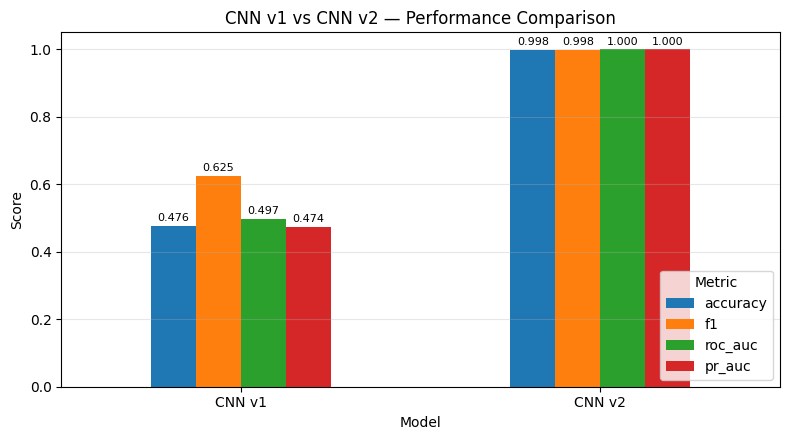

In [34]:
fig, ax = plt.subplots(figsize=(8, 4.5))
bars = plot_df.set_index("model_short")[["accuracy", "f1", "roc_auc", "pr_auc"]].plot(
    kind="bar",
    ax=ax
)

ax.set_title("CNN v1 vs CNN v2 — Performance Comparison")
ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.legend(title="Metric", loc="lower right")
ax.grid(axis="y", alpha=0.3)
plt.xticks(rotation=0)

# Add bar labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", padding=2, fontsize=8)

plt.tight_layout()
plt.show()



18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


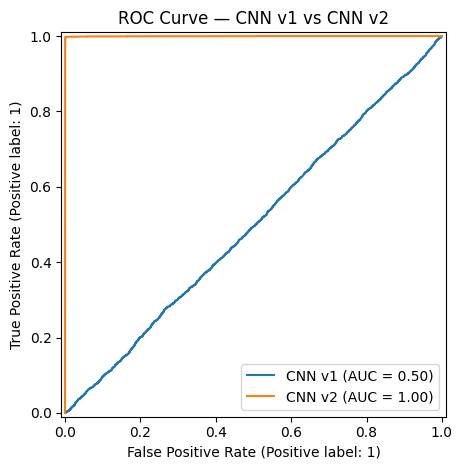

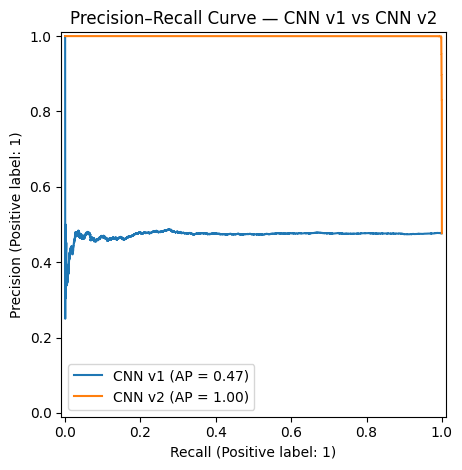

In [30]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

def get_probs(model, Xte, batch_size=512):
    return model.predict(Xte, batch_size=batch_size).ravel()

# Get probabilities
probs_v1 = get_probs(cnn_model, X_test_pad)       # baseline cnn model object
probs_v2 = get_probs(cnn_model_v2, X_test_pad)    # improved cnn model object

# ROC overlay
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, probs_v1, ax=ax, name="CNN v1")
RocCurveDisplay.from_predictions(y_test, probs_v2, ax=ax, name="CNN v2")
ax.set_title("ROC Curve — CNN v1 vs CNN v2")
plt.tight_layout()
plt.show()

# PR overlay
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, probs_v1, ax=ax, name="CNN v1")
PrecisionRecallDisplay.from_predictions(y_test, probs_v2, ax=ax, name="CNN v2")
ax.set_title("Precision–Recall Curve — CNN v1 vs CNN v2")
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd

comparison_df = pd.DataFrame([
    cnn_v1_metrics,
    cnn_v2_metrics
])

# Rename models to clean academic labels
comparison_df["model"] = [
    "CNN v1 (baseline)",
    "CNN v2 (class-weighted + stronger embedding)"
]

# Reorder + round
comparison_df = comparison_df[
    ["model", "accuracy", "f1", "roc_auc", "pr_auc"]
].round(4)

comparison_df


,model,accuracy,f1,roc_auc,pr_auc
0,CNN v1 (baseline),0.4756,0.6255,0.4974,0.4736
1,CNN v2 (class-weighted + stronger embedding),0.9979,0.9978,0.9997,0.9998


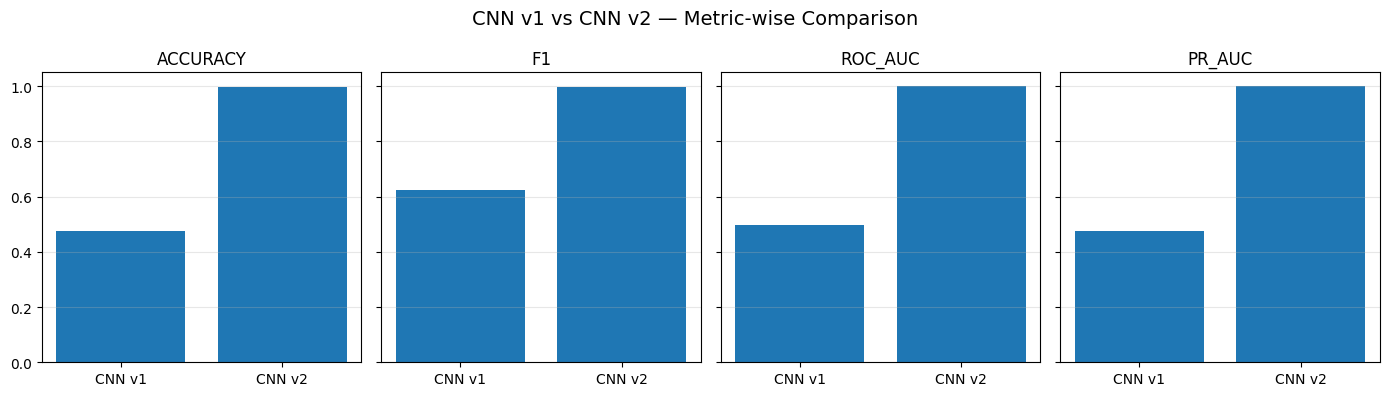

In [36]:
import matplotlib.pyplot as plt

metrics = ["accuracy", "f1", "roc_auc", "pr_auc"]

fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True)

for i, metric in enumerate(metrics):
    axes[i].bar(
        ["CNN v1", "CNN v2"],
        comparison_df[metric],
    )
    axes[i].set_title(metric.upper())
    axes[i].set_ylim(0, 1.05)
    axes[i].grid(axis="y", alpha=0.3)

fig.suptitle("CNN v1 vs CNN v2 — Metric-wise Comparison", fontsize=14)
plt.tight_layout()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


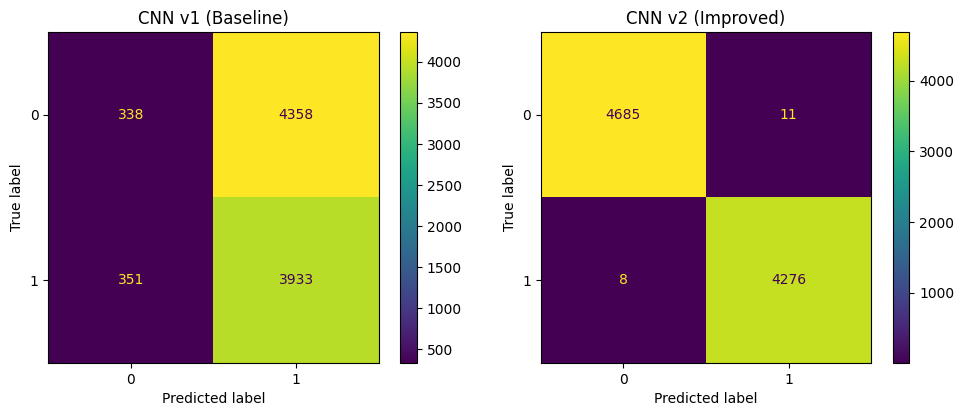

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get predictions
preds_v1 = (cnn_model.predict(X_test_pad, batch_size=512).ravel() >= 0.5).astype(int)
preds_v2 = (cnn_model_v2.predict(X_test_pad, batch_size=512).ravel() >= 0.5).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(
    y_test, preds_v1, ax=axes[0], values_format="d"
)
axes[0].set_title("CNN v1 (Baseline)")

ConfusionMatrixDisplay.from_predictions(
    y_test, preds_v2, ax=axes[1], values_format="d"
)
axes[1].set_title("CNN v2 (Improved)")

plt.tight_layout()
plt.show()
